In [2]:
from loader import MoleculeDataset
from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from model import GNN, GNN_graphpred
from sklearn.metrics import roc_auc_score
from splitters import scaffold_split, random_split
import pandas as pd

import os
import shutil

dataset_str = 'tox21'
dataset = MoleculeDataset("dataset/" + dataset_str, dataset=dataset_str)
smiles_list = pd.read_csv('dataset/' + dataset_str + '/processed/smiles.csv', header=None)[0].tolist()
train_dataset, valid_dataset, test_dataset = scaffold_split(dataset, smiles_list, null_value=0, frac_train=0.8,frac_valid=0.1, frac_test=0.1)


7831 7831
7831
7831


RDKit WARNING: [16:43:31] WARNING: not removing hydrogen atom without neighbors
[16:43:31] WARNING: not removing hydrogen atom without neighbors


In [13]:
print(train_dataset[5])
print(train_dataset[5].x)
print(train_dataset[5].edge_index)
print(train_dataset[5].edge_attr)
print(train_dataset[5].y) ## if more than 1 length -> multilabel task

Data(y=[12], edge_index=[2, 26], edge_attr=[26, 2], x=[14, 2], id=[1])
tensor([[5, 0],
        [5, 0],
        [5, 0],
        [5, 0],
        [7, 0],
        [7, 0],
        [5, 0],
        [5, 0],
        [7, 0],
        [5, 0],
        [7, 0],
        [5, 0],
        [5, 0],
        [5, 0]])
tensor([[ 0,  1,  1,  2,  1,  3,  3,  4,  3,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10,  9, 11, 11, 12, 11, 13],
        [ 1,  0,  2,  1,  3,  1,  4,  3,  5,  3,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11,  9, 12, 11, 13, 11]])
tensor([[1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [0, 0],
        [0, 0]])
tensor([-1., -1., -1., -1., -1., -1., -1

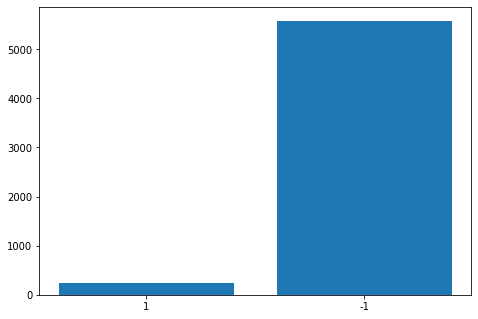

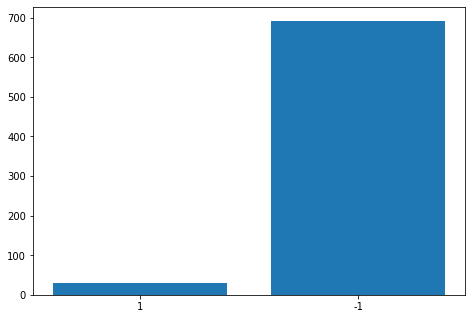

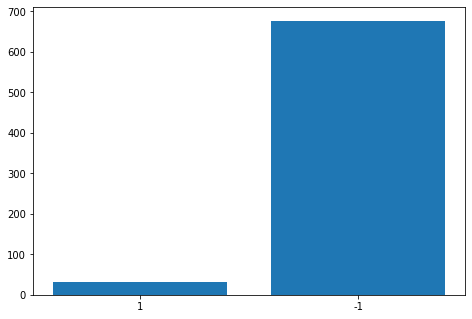

In [2]:
def show_imbalance(dataset):
  ## get only y labels in NR-ER tasks
  y = []
  for i, row in enumerate(dataset):
    y.append(int(row.y[0]))

  # print(len(y), y)
  #
  import matplotlib.pyplot as plt
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  x_axis = ['1', '-1']
  y_axis = [y.count(1), y.count(-1)]
  ax.bar(x_axis, y_axis)
  plt.show()
  return 

show_imbalance(train_dataset)
show_imbalance(valid_dataset)
show_imbalance(test_dataset)

In [3]:
def get_cls_num(dataset):
  from collections import Counter
  y = []
  for i, row in enumerate(dataset):
    li = str(list(map(int, row.y)))
    y.append(li)

  cnt = Counter(y)
  return cnt

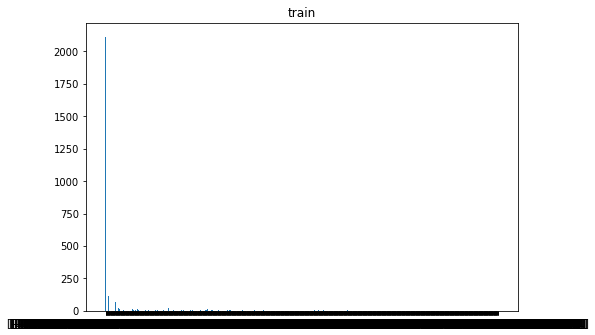

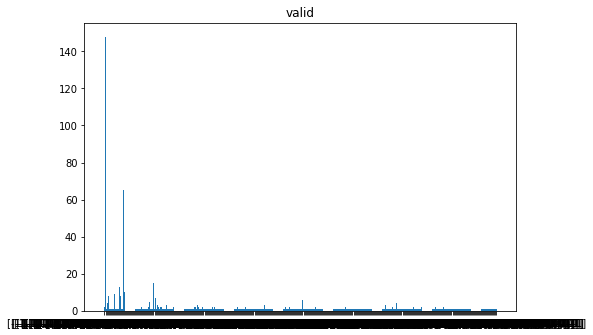

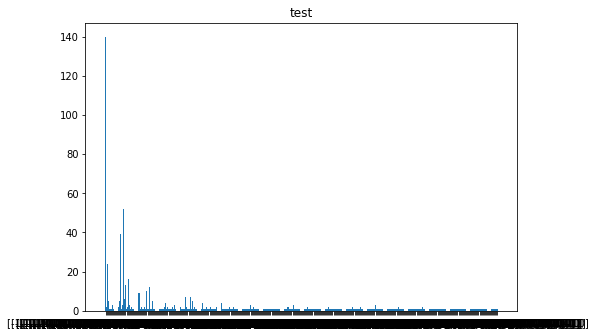

In [4]:
from collections import Counter
def show_longtailed(dataset, title="train"):
  y = []
  for i, row in enumerate(dataset):
    li = str(list(map(int, row.y)))
    y.append(li)

  cnt = Counter(y)
  # print(len(y), y)
  #
  def map_keys(keys):
    dic = dict()
    for i, k in enumerate(keys):
      dic[k] = i
    return dic.keys()
  import matplotlib.pyplot as plt
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  x_axis = map_keys(cnt.keys())
  y_axis = [ v for k, v in cnt.items()]
  ax.bar(x_axis, y_axis)
  plt.title(title)
  plt.show()
  return 

show_longtailed(train_dataset, "train")
show_longtailed(valid_dataset, "valid")
show_longtailed(test_dataset, "test")


In [14]:
from torch.utils.data.sampler import WeightedRandomSampler
def get_weighted_sampler(dataset):
  y = []
  for i, row in enumerate(dataset):
    li = str(list(map(int, row.y)))
    y.append(li)

  target = np.array(y)
  # print ('target train -1/0/1: {}/{}/{}'.format(
  #     len(np.where(target == -1)[0]), len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))
  print("There are total {} instances".format(len(target)))
  print("There are total {} unique labels".format(len(set(target))))
  weight = dict()
  for t in np.unique(target):
      weight[t] = 1 / len(np.where(target == t)[0]) 
  # print(weight)
  samples_weight = np.array([weight[t] for t in target])
  samples_weight = torch.from_numpy(samples_weight)
  # print(samples_weight[:32])
  samples_weigth = samples_weight.double()
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
  # target = torch.from_numpy(target).long()
  # print(target[:32])
  return sampler
get_weighted_sampler(valid_dataset)

783
385


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers = 4, sampler=get_weighted_sampler(train_dataset))
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers = 4, sampler=get_weighted_sampler(valid_dataset))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers = 4,
sampler=get_weighted_sampler(test_dataset))

from collections import Counter
for i, batch in enumerate(train_loader):
  # print(len(batch.y))
  resh = batch.y.reshape(-1, 12)[:,4].numpy()
  counter = Counter(resh)
  print("batch {} 1/0/-1 {}/{}/{}".format(i, counter[1], counter[0], counter[-1]))

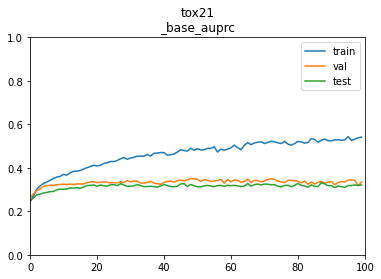

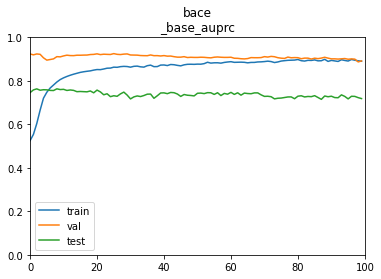

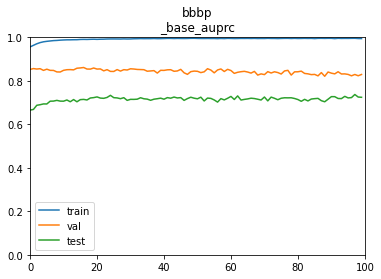

In [27]:

def plot_result(log, opt='test', title="lossweighted", metric="PRC"):
  import matplotlib.pyplot as plt
  options = [2, 4, -1]
  # if opt=='test':
  #   opt = -1
  # elif opt=='val':
  #   opt = 3
  # else:
  #   opt = 1
  with open(log, 'r') as f:
    contents = f.readlines()
    dataset = contents[0]
    if metric=="PRC":
      results = contents[2::2]
    else:
      results = contents[1::2]
    assert results[0].split()[0] == metric
    for opt in options:
      y = [float(line.split()[opt]) for line in results]
      x = range(len(y))
      # fig = plt.figure()
      # ax = fig.add_axes([0,0,1,1])
      plt.axis([0,len(x), 0.0, 1])
      plt.plot(x[:], y[:],)
    plt.title("{}_{}".format(dataset, title))
    plt.legend(['train','val','test'])
    plt.show()
  
plot_result('./log/tox21_False.log', title="base_auprc")
plot_result('./log/bace_False.log', title="base_auprc")
plot_result('./log/bbbp_False.log', title="base_auprc")
# plot_result('./log/tox21_True.log',title="weightedSW_auprc")